In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.constants as const
mpl.rc('xtick', direction='out', top=True)
mpl.rc('ytick', direction='out', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.xmargin'] = 0

# Problem 1

In [2]:
# Units used in this problem:
# g/mL, cm, mol, radians
concentration = np.arange(0.5,2.1,0.5) * 1e-3 # mg/mL -> g/mL
angle = np.linspace(np.pi / 6, 2 * np.pi / 3, 4) #30 to 120 degrees: pi/6 to 2pi/3

wavelength = 546e-7 # 546 nm -> cm
n = 1.502
dndc = 0.108 # already in units of inverse concentration

In [3]:
q_sq = np.sin(angle/2) ** 2

In [4]:
Rt = np.array([[.258,.229,.195,.178], # c = 0.5
                 [.433,.392,.348,.317], # c = 1.0
                 [.543,.505,.455,.415], # c = 1.5
                 [.622,.573,.532,.494]]) * 1e-4 # c = 2.0

K = ((2 * np.pi * n * dndc) ** 2) / (const.N_A * wavelength ** 4)

Kc = K * concentration

In [5]:
KcRt = (Kc / Rt.T).T # Big 2D Array of Kc / Rt so we can do the data analysis using fewer function calls.

In [6]:
q_fit = np.polyfit(q_sq, KcRt.T, 1) # extrapolation to q = 0. q_fit[1] = y-intercepts
c_fit = np.polyfit(concentration, KcRt, 1) # extrapolation to c = 0.
qc_fit = np.polyfit(concentration, q_fit[1], 1) # This value is the one used to find the molecular weight.
qc_fit2 = np.polyfit(q_sq, c_fit[1], 1) # intercept should match the other qc_fit methodology

## Conclusions

In [7]:
MW = 1/qc_fit[1]
print(f"Molecular weight is: {MW:.0f} g/mol")

Molecular weight is: 367118 g/mol


In [8]:
# to find 2nd virial:
# at q = 0, Kc/Rt = 1/M + 2A_2 * c
# so the slope vs. concentration is 2A_2
B2 = qc_fit[0] / 2
print(f"Second Virial Coefficient is: {B2:.3e} mol-mL/g^2")

Second Virial Coefficient is: 8.376e-04 mol-mL/g^2


In [9]:
# to find radius of gyration:
# at c = 0, Kc/Rt = 1/MW + 1/3MW * (q * Rg)^2
# so the slope vs. q^2 is Rg^2 / 3MW
# but the slope against sin(theta/2)^2 needs an additional factor of wavelenth/4pi all squared.
# I'll take it outside the square root.
Rg = wavelength / (4 * np.pi * n) * np.sqrt(3 * qc_fit2[0] * MW) * 1e7 # converting to nanometers.
print(f"Radius of Gyration is: {Rg:.1f} nm")

Radius of Gyration is: 48.6 nm


## Zimm Plot

In [10]:
KcRt_0 = np.zeros((5,5))
KcRt_0[1:,1:] = KcRt
KcRt_0[0,1:] = c_fit[1]
KcRt_0[1:,0] = q_fit[1]
KcRt_0[0,0] = qc_fit[1]

In [11]:
q_sq_ext = np.zeros(5)
q_sq_ext[1:] = q_sq
conc_ext = np.zeros(5)
conc_ext[1:] = concentration

factor = 3000

q_sq_mxc = np.full((5,5), q_sq_ext) + factor * np.full((5,5), conc_ext).T

In [12]:
c_fit_ext = np.polyfit(conc_ext, KcRt_0, 1)
q_fit_ext = np.polyfit(q_sq_ext, KcRt_0.T, 1)

q_lines = np.polyval(c_fit_ext, np.full((5,5), conc_ext).T)
c_lines = np.polyval(q_fit_ext, np.full((5,5), q_sq_ext).T).T

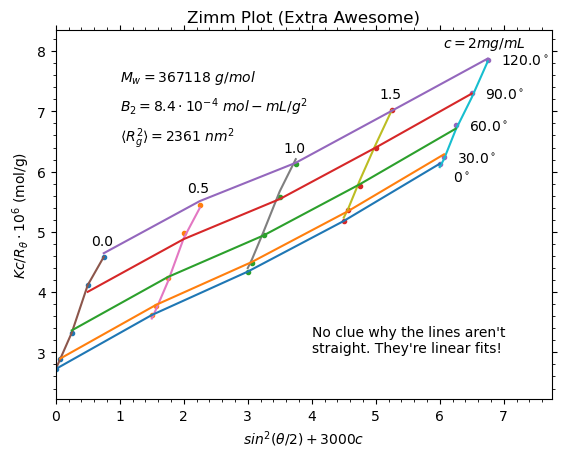

In [13]:
plt.plot(q_sq_mxc.T, KcRt_0.T * 1e6, ".")
plt.plot(q_sq_mxc.T, q_lines.T * 1e6)
plt.plot(q_sq_mxc, c_lines * 1e6)
plt.title("Zimm Plot (Extra Awesome)")
plt.xlabel(rf"$sin^2(\theta/2) + {factor}c$")
plt.ylabel(r"$Kc/R_{\theta} \cdot 10^6$ (mol/g)")
plt.text(1, 7.5, rf"$M_w = {MW:.0f} \ g/mol$")
plt.text(1, 7, rf"$B_2 = {B2*10000:.1f}" + r"\cdot 10^{-4} \ mol-mL/g^2$")
plt.text(1, 6.5, rf"$\langle R_g^2 \rangle = {Rg**2:.0f} \ nm^2$")
for i in range(4):
    plt.text(q_sq_mxc[i,4] - 0.2, KcRt_0[i,4] * 1e6 + 0.2, conc_ext[i]*1000)

angle_deg = np.linspace(0, 120, 5)
for i in range(1,5):
    plt.text(q_sq_mxc[4,i] + 0.2, KcRt_0[4,i] * 1e6 - 0.1, rf"${angle_deg[i]}^\circ$")

plt.text(q_sq_mxc[4,0] + 0.2, KcRt_0[4,0] * 1e6 - 0.3, rf"$0^\circ$")
plt.text(q_sq_mxc[4,4] -0.7, KcRt_0[4,4] * 1e6 + 0.2, rf"$c = 2 mg/mL$")

plt.text(4,3, "No clue why the lines aren't\nstraight. They're linear fits!")

plt.xlim(0, np.max(q_sq_mxc) + 1)
plt.ylim(np.min(KcRt_0) * 1e6 - 0.5, np.max(KcRt_0) * 1e6 + 0.5);

# Problem 2

In [14]:
# Solvents in order: MEK, Dichloroethane, Toluene
solvents = ["MEK", "Dichloroethane", "Toluene"]
intercepts = np.array([0.840, 1.50, 2.80]) # c/Rt without any scaling factor. I believe the units are g-cm/mL (or g/cm^2)
c_0 = np.array([0.551, 1.05, 1.09]) # dimensionless
q_0 = np.array([230, 870, 800]) # cm^3/g (or mL/g)

ns = np.array([1.359, 1.423, 1.472])
dndcs = np.array([0.230, 0.167, 0.118])
wavelength = 546e-7

Ks = ((2 * np.pi * ns * dndcs) ** 2) / (const.N_A * wavelength ** 4) 

KcRts = Ks*intercepts # units of g/mol, will give MW

In [15]:
MWs = 1/KcRts
for i in range(3):
    print(f"Molecular Weight in {solvents[i]}: {MWs[i]:.0f} g/mol")

Molecular Weight in MEK: 1651916 g/mol
Molecular Weight in Dichloroethane: 1600397 g/mol
Molecular Weight in Toluene: 1604812 g/mol


In [16]:
B2s = q_0 * KcRts / 2 # units: cm^3/g * mol/g = mol-ml/g^2
for i in range(3):
    print(f"B2 in {solvents[i]}: {B2s[i]*1e5:.1f} * 10^-5 mol-mL/g^2")

B2 in MEK: 7.0 * 10^-5 mol-mL/g^2
B2 in Dichloroethane: 27.2 * 10^-5 mol-mL/g^2
B2 in Toluene: 24.9 * 10^-5 mol-mL/g^2


In [17]:
Rg2s = (wavelength / (4 * np.pi * n)) ** 2 * 3 * (c_0 * KcRts) * MW * 1e14
# units: cm^2 (wavelength) / dimensionless * dimensionless * mol/g * g/mol * conversion factor = nm^2
for i in range(3):
    print(f"Rg squared in {solvents[i]}: {Rg2s[i]:.1f} nm^2")

Rg squared in MEK: 307.4 nm^2
Rg squared in Dichloroethane: 604.7 nm^2
Rg squared in Toluene: 626.0 nm^2


I conclude that Toluene is the most effective solvent for this polymer because it results in the highest radius of gyration, meaning the polymer chain is the most stretched out.